# Cryptocurrency Price Prediction using Twitter Sentiment Analysis 


---


# Authors:
- Daniil Volovik, Winnie Nguyen, Fabio Turazzi

Cryptocurrencies are growing in relevance in modern days, gaining support from both big corporations and the general public. The fluctuations in prices have drawn many enthusiasts to scrutinize and discuss across social media platforms to get an upper hand while trading.

In this project, we examined the relationships between general opinion on Twitter and the prices of a selection of currencies. After scraping the data, we performed Sentiment Analysis on tweets and trained Machine Learning models to predict daily prices from different cryptocurrencies. 

## 1. Data Preparation
### 1.1 Importing Libraries and Datasets

In [ ]:
import pandas as pd
import numpy as np
import warnings

The tweets and coins datasets used for this analysis were scraped using Twint and CoingeckoAPI, respectively. We extracted Sentiment Analysis from tweets using the VADER library, seen in the scraping_and_preprocessing/vader_preprocessing.py directory of this project.

In [ ]:
df_tweets = pd.read_csv('data/tweets/tweets_sentiment.csv')
df_prices = pd.read_csv('data/coingecko/coingecko.csv')

### 1.2 Dropping Unnecessary Columns
Both datasets contain excessive information and metadata, which were dropped before we began exploring them.

In [ ]:
df_tweets = df_tweets.drop(['id', 'conversation_id', 'created_at','timezone','place','hashtags',
                            'cashtags', 'user_id','username','name', 'tweet',
                            'link','urls','photos', 'video','thumbnail','source','user_rt_id',
                            'retweet_id','reply_to','language','retweet','quote_url','near','geo','user_rt',
                            'retweet_date','translate','trans_src','trans_dest','Unnamed: 0', 'mentions'], axis=1)
df_tweets.rename(columns={"decoded_tweet": "tweet", "search":"coin_name"}, inplace=True)
df_tweets

df_prices = df_prices.drop(['index', 'name'], axis=1)
df_prices.rename(columns={"price_usd": "price", "market_cap_usd": "market_cap", 
                   "total_vol_usd": "total_vol", "id":"coin_name"}, inplace=True)
df_prices

,coin_name,price,market_cap,total_vol,date
0,cardano,0.659472,2.091005e+10,8.483795e+09,08-02-2021
1,cardano,0.626357,1.985498e+10,6.225004e+09,07-02-2021
2,cardano,0.538552,1.720209e+10,5.138348e+09,06-02-2021
3,cardano,0.441599,1.412487e+10,2.526990e+09,05-02-2021
4,cardano,0.441216,1.404678e+10,2.963647e+09,04-02-2021
...,...,...,...,...,...
12812,yearn-finance,3793.033675,1.144837e+08,8.185937e+06,04-08-2020
12813,yearn-finance,4063.531281,1.212525e+08,9.198283e+06,03-08-2020
12814,yearn-finance,3863.416015,1.156429e+08,9.230661e+06,02-08-2020
12815,yearn-finance,4128.207821,1.235146e+08,1.945850e+07,01-08-2020


In the tweets dataset, we can see the columns "neg", "neu", and "pos", which reflect the sentiment scores for a given tweet. The value "compound" represents a combination of the three. We experimented with using either the compound or the 3 separate features to identify the configuration that rendered best results.

In [ ]:
df_tweets

,date,time,replies_count,retweets_count,likes_count,coin_name,tweet,neg,neu,pos,compound
0,2013-03-29,13:05:03,0,12,18,cryptocurrency,Bitcoin: The Cyberpunk Cryptocurrency http://...,0.0,1.000,0.000,0.0000
1,2013-04-15,10:37:11,3,34,17,cryptocurrency,Bitcoin Isn't the Only Cryptocurrency in Town ...,0.0,1.000,0.000,0.0000
2,2013-04-14,18:34:04,15,153,61,cryptocurrency,"#Bitcoin, a ""cryptocurrency"", went on a tear l...",0.0,1.000,0.000,0.0000
3,2013-04-18,14:04:24,2,27,26,cryptocurrency,I'm going to make my OWN crypto-currency and e...,0.0,0.885,0.115,0.3810
4,2013-05-09,15:14:19,4,66,30,cryptocurrency,"Your momma's cryptocurrency is so virtual, she...",0.0,1.000,0.000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...
824903,2019-12-16,9:18:10,27,14,21,ripple,پیامرسان ها درآمد سرشاری دارند اما #linkup بزو...,0.0,0.886,0.114,0.5972
824904,2020-10-04,18:36:31,7,3,50,ripple,Hi 25 cent #xrp 😁,0.0,0.727,0.273,0.4588
824905,2020-10-27,15:30:23,2,3,47,ripple,$ocean #ALLTHEBANKS $Ocean $ewt $dot $qnt $xr...,0.0,1.000,0.000,0.0000
824906,2020-11-21,8:28:39,2,0,75,ripple,Hi .42 cent #xrp 🤘🤝🤙✅🍺,0.0,0.842,0.158,0.4939


### 1.3 Experimenting with threshold of number of likes
We have also experimented with a cutoff point for the minimum number of likes to consider a tweet in the analysis. We believe this helps estimate the relevance of tweets and exclude unwanted noise from the analysis. The setting with most accurate results was a threshold of 200 likes to include a tweet.

In [ ]:
df_tweets = df_tweets[df_tweets.likes_count >= 200]

### 1.4 Experimenting with dropping some of the coins
We have also experimented with the combination of coins included in the model. We scraped data regarding 7 coins, having different price ranges and behaviors among them. Since our daily price data made necessary to combine different coins in order to train our models, we attempted to exclude the most discrepant ones. We also recognize here that the best approach for this problem would be analyzing each coin separately, but we did not have access to enough data (e.g. hourly) to do that.

In [ ]:
df_prices = df_prices[df_prices.coin_name != 'cardano']
df_prices = df_prices[df_prices.coin_name != 'tezos']
df_prices = df_prices[df_prices.coin_name != 'ripple']

### 1.5 Formatting dates

In [ ]:
#fix date on both dataframes for join
df_tweets['date'] = pd.to_datetime(df_tweets['date'], format='%Y-%m-%d').dt.strftime('%Y-%m-%d')
df_prices['date'] = pd.to_datetime(df_prices['date'], format='%d-%m-%Y').dt.strftime('%Y-%m-%d')

df_prices.head()

,coin_name,price,market_cap,total_vol,date
3951,bitcoin,39279.41287,7.320000e+11,5.707687e+10,2021-02-07
3952,bitcoin,38007.83223,7.060000e+11,4.744626e+10,2021-02-06
3953,bitcoin,36816.50808,6.860000e+11,5.449481e+10,2021-02-05
3954,bitcoin,37494.71762,6.960000e+11,4.976214e+10,2021-02-04
3955,bitcoin,35485.98593,6.610000e+11,5.073070e+10,2021-02-03


### 1.6 Grouping General Tweets
In our Twitter scraping process, we queried two types of tweets. First, the coin-specific ones, which we will relate to the respective datapoints in the prices dataset. The others, were general tweets that reflected general sentiment torwards crypto in a given day, with more broad query keywords. These will be considered as a separate property for all cryptocurrencies in the models.

In [ ]:
#Separate a dataframe for general tweets - getting rows based on coin_name
df_tweets_general = df_tweets.loc[(df_tweets["coin_name"] == "cryptocurrency") 
                              | (df_tweets["coin_name"] == "cryptocurrencies") 
                              | (df_tweets["coin_name"] == "crypto-currency")]


df_tweets_general

,date,time,replies_count,retweets_count,likes_count,coin_name,tweet,neg,neu,pos,compound
73,2014-02-25,13:00:44,35,5316,2793,cryptocurrency,"A machine learning researcher, a crypto-curren...",0.000,1.000,0.000,0.0000
85,2014-03-01,0:12:17,10,754,433,cryptocurrency,"""A machine learning researcher, a crypto-curre...",0.000,1.000,0.000,0.0000
107,2014-03-26,10:48:22,3,537,389,cryptocurrency,"Check out this video :D Fuckcoin, the fun appr...",0.000,0.635,0.365,0.8240
136,2014-05-07,10:13:01,1,5653,231,cryptocurrency,"Crypto-Currency Prices - Bitcoin, Litecoin, an...",0.000,1.000,0.000,0.0000
202,2014-09-15,23:51:24,34,165,436,cryptocurrency,PREDICTION: A company will invent its own cryp...,0.069,0.931,0.000,-0.1027
...,...,...,...,...,...,...,...,...,...,...,...
378195,2021-02-09,18:47:10,28,37,290,cryptocurrency,How is the third largest cryptocurrency in the...,0.128,0.872,0.000,-0.3597
378196,2021-02-09,18:46:14,0,37,233,cryptocurrency,@elonmusk @Tesla If you are true to your cli...,0.000,0.865,0.135,0.4215
378198,2021-02-09,18:40:17,30,164,537,cryptocurrency,"Lawyers sue CBN, SEC over cryptocurrency ban ...",0.340,0.660,0.000,-0.5574
378211,2021-02-09,17:04:37,25,145,395,cryptocurrency,You see #Dogecoin is much more then just a #cr...,0.020,0.720,0.260,0.9403


#### Assign weights for tweets based on number of likes, replies, and retweets
In order to consider the relevance of tweets (e.g. tweets with many retweets have a larger reach and should be more significant), we assigned weights for each of the important features. The weights were assigned to retweets (0.7), likes (0.2), and replies (0.1). 

In [ ]:
#Setting weights for retweets, likes, and replies based on the daily average for a given coin
df_tweets_general['weight_retweets'] = df_tweets_general['retweets_count'] / df_tweets_general.groupby(['date'])['retweets_count'].transform('sum')
df_tweets_general['weight_likes'] = df_tweets_general['likes_count'] / df_tweets_general.groupby(['date'])['likes_count'].transform('sum')
df_tweets_general['weight_replies'] = df_tweets_general['replies_count'] / df_tweets_general.groupby(['date'])['replies_count'].transform('sum')

df_tweets_general = df_tweets_general.fillna(value=0.0001)

#Set an accumulated weight considering the 3 features, using specific weights for retweets, likes and replies
#Weight assigned to retweets is higher, since it seems more significant for measuring the relevance of a tweet
df_tweets_general['accum_weight'] = (df_tweets_general['weight_retweets'] * 0.7 +
                             df_tweets_general['weight_likes'] * 0.2 +
                             df_tweets_general['weight_replies'] * 0.1)

#Drop the individual weights
df_tweets_general = df_tweets_general.drop(['weight_retweets', 'weight_likes', 'weight_replies'], axis=1)
df_tweets_general.head()

,date,time,replies_count,retweets_count,likes_count,coin_name,tweet,neg,neu,pos,compound,accum_weight
73,2014-02-25,13:00:44,35,5316,2793,cryptocurrency,"A machine learning researcher, a crypto-curren...",0.000,1.000,0.000,0.0000,0.332976
85,2014-03-01,0:12:17,10,754,433,cryptocurrency,"""A machine learning researcher, a crypto-curre...",0.000,1.000,0.000,0.0000,0.499768
107,2014-03-26,10:48:22,3,537,389,cryptocurrency,"Check out this video :D Fuckcoin, the fun appr...",0.000,0.635,0.365,0.8240,0.500000
136,2014-05-07,10:13:01,1,5653,231,cryptocurrency,"Crypto-Currency Prices - Bitcoin, Litecoin, an...",0.000,1.000,0.000,0.0000,0.333251
202,2014-09-15,23:51:24,34,165,436,cryptocurrency,PREDICTION: A company will invent its own cryp...,0.069,0.931,0.000,-0.1027,0.334280


#### Grouping tweets using weighted average
The previously calculated accumulated weight was then used to group general Twitter sentiment by day. This was done in order to prepare the data to be joined with currency prices.

In [ ]:
# Define a lambda function to compute the weighted avg:
weightedAvg = lambda x: np.average(x, weights=df_tweets_general.loc[x.index, "accum_weight"])

# Groupby search (coin) and date, using the average calculated for retweets, likes, and replies
df_tweets_general = df_tweets_general.groupby(["date"], as_index=False).agg(positive = ("pos", weightedAvg),
                                                 negative = ("neg", weightedAvg),
                                                 neutral = ("neu", weightedAvg),
                                                 compound = ("compound", weightedAvg),
                                                 total_tweets = ('tweet', 'count'),
                                                 total_retweets = ('retweets_count',sum))

df_tweets_general = df_tweets_general.reset_index(drop=True)

df_tweets_general.head()

,date,positive,negative,neutral,compound,total_tweets,total_retweets
0,2014-02-25,0.000,0.000,1.000,0.0000,3,15973
1,2014-03-01,0.000,0.000,1.000,0.0000,2,1509
2,2014-03-26,0.365,0.000,0.635,0.8240,2,1074
3,2014-05-07,0.000,0.000,1.000,0.0000,3,16965
4,2014-09-15,0.000,0.069,0.931,-0.1027,3,493


#### Renaming Columns

In [ ]:
#Renaming the columns for later merge
df_tweets_general.rename(columns={"positive": "positive_general", "negative": "negative_general","neutral": "neutral_general",
                   "compound": "compound_general", "total_retweets": "total_retweets_general", "total_tweets": "total_tweets_general"}, inplace=True)

df_tweets_general.head()

,date,positive_general,negative_general,neutral_general,compound_general,total_tweets_general,total_retweets_general
0,2014-02-25,0.000,0.000,1.000,0.0000,3,15973
1,2014-03-01,0.000,0.000,1.000,0.0000,2,1509
2,2014-03-26,0.365,0.000,0.635,0.8240,2,1074
3,2014-05-07,0.000,0.000,1.000,0.0000,3,16965
4,2014-09-15,0.000,0.069,0.931,-0.1027,3,493


### 1.7 Repeating the aggregation for other tweets

In [ ]:
#Setting weights for retweets, likes, and replies based on the daily average for a given coin
df_tweets['weight_retweets'] = df_tweets['retweets_count'] / df_tweets.groupby(['coin_name', 'date'])['retweets_count'].transform('sum')
df_tweets['weight_likes'] = df_tweets['likes_count'] / df_tweets.groupby(['coin_name', 'date'])['likes_count'].transform('sum')
df_tweets['weight_replies'] = df_tweets['replies_count'] / df_tweets.groupby(['coin_name', 'date'])['replies_count'].transform('sum')

#Set an accumulated weight considering the 3 features, using specific weights for retweets, likes and replies
#Weight assigned to retweets is higher, since it seems more significant for measuring the relevance of a tweet
df_tweets['accum_weight'] = (df_tweets['weight_retweets'] * 0.7 +
                             df_tweets['weight_likes'] * 0.2 +
                             df_tweets['weight_replies'] * 0.1)

#Drop the individual weights
df_tweets = df_tweets.drop(['weight_retweets', 'weight_likes', 'weight_replies'], axis=1)
df_tweets.head()

,date,time,replies_count,retweets_count,likes_count,coin_name,tweet,neg,neu,pos,compound,accum_weight
73,2014-02-25,13:00:44,35,5316,2793,cryptocurrency,"A machine learning researcher, a crypto-curren...",0.000,1.000,0.000,0.0000,0.332976
85,2014-03-01,0:12:17,10,754,433,cryptocurrency,"""A machine learning researcher, a crypto-curre...",0.000,1.000,0.000,0.0000,0.499768
107,2014-03-26,10:48:22,3,537,389,cryptocurrency,"Check out this video :D Fuckcoin, the fun appr...",0.000,0.635,0.365,0.8240,0.500000
136,2014-05-07,10:13:01,1,5653,231,cryptocurrency,"Crypto-Currency Prices - Bitcoin, Litecoin, an...",0.000,1.000,0.000,0.0000,0.333251
202,2014-09-15,23:51:24,34,165,436,cryptocurrency,PREDICTION: A company will invent its own cryp...,0.069,0.931,0.000,-0.1027,0.334280


#### Group tweets using weighted average

In [ ]:
# Define a lambda function to compute the weighted avg:
weightedAvg = lambda x: np.average(x, weights=df_tweets.loc[x.index, "accum_weight"])

# Groupby search (coin) and date, using the average calculated for retweets, likes, and replies
df_tweets = df_tweets.groupby(["coin_name", "date"], as_index=False).agg(positive = ("pos", weightedAvg),
                                                 negative = ("neg", weightedAvg),
                                                 neutral = ("neu", weightedAvg),
                                                 compound = ("compound", weightedAvg),
                                                 total_tweets = ('tweet', 'count'),
                                                 total_retweets = ('retweets_count',sum))

df_tweets = df_tweets.reset_index(drop=True)

df_tweets.head()

,coin_name,date,positive,negative,neutral,compound,total_tweets,total_retweets
0,bitcoin,2014-04-27,0.055000,0.0,0.945000,0.1280,1,24
1,bitcoin,2014-06-08,0.101000,0.0,0.899000,0.4215,1,100
2,bitcoin,2014-07-18,0.182053,0.0,0.817947,0.3818,2,1628
3,bitcoin,2014-08-12,0.000000,0.0,1.000000,0.0000,1,126
4,bitcoin,2014-09-16,0.184000,0.0,0.816000,0.4019,1,342


#### Drop days with zero tweets
In order to remove bias from the model, we excluded days that presented 0 tweets. These days would induce innacurate predictions to the model, considering that any default sentiment scores we chose to them would be arbitrary (e.g. 0, 0, 0) and not reflect meaningful sentiment during that day.

In [ ]:
#Drop days with total_tweets = 0
df_tweets = df_tweets[df_tweets.total_tweets > 0]
df_tweets_general = df_tweets_general[df_tweets_general.total_tweets_general > 0]

### 1.7 Converting Dates to Ordinal for Modelling

In [ ]:
df_prices

,coin_name,price,market_cap,total_vol,date
3951,bitcoin,39279.412870,7.320000e+11,5.707687e+10,2021-02-07
3952,bitcoin,38007.832230,7.060000e+11,4.744626e+10,2021-02-06
3953,bitcoin,36816.508080,6.860000e+11,5.449481e+10,2021-02-05
3954,bitcoin,37494.717620,6.960000e+11,4.976214e+10,2021-02-04
3955,bitcoin,35485.985930,6.610000e+11,5.073070e+10,2021-02-03
...,...,...,...,...,...
12812,yearn-finance,3793.033675,1.144837e+08,8.185937e+06,2020-08-04
12813,yearn-finance,4063.531281,1.212525e+08,9.198283e+06,2020-08-03
12814,yearn-finance,3863.416015,1.156429e+08,9.230661e+06,2020-08-02
12815,yearn-finance,4128.207821,1.235146e+08,1.945850e+07,2020-08-01


In [ ]:
import datetime as dt
# Prepare dates for the regression
df_tweets['date']=pd.to_datetime(df_tweets['date']).map(dt.datetime.toordinal)
df_tweets_general['date']=pd.to_datetime(df_tweets_general['date']).map(dt.datetime.toordinal)
df_prices['date']=pd.to_datetime(df_prices['date']).map(dt.datetime.toordinal)

df_prices


,coin_name,price,market_cap,total_vol,date
3951,bitcoin,39279.412870,7.320000e+11,5.707687e+10,737828
3952,bitcoin,38007.832230,7.060000e+11,4.744626e+10,737827
3953,bitcoin,36816.508080,6.860000e+11,5.449481e+10,737826
3954,bitcoin,37494.717620,6.960000e+11,4.976214e+10,737825
3955,bitcoin,35485.985930,6.610000e+11,5.073070e+10,737824
...,...,...,...,...,...
12812,yearn-finance,3793.033675,1.144837e+08,8.185937e+06,737641
12813,yearn-finance,4063.531281,1.212525e+08,9.198283e+06,737640
12814,yearn-finance,3863.416015,1.156429e+08,9.230661e+06,737639
12815,yearn-finance,4128.207821,1.235146e+08,1.945850e+07,737638


### 1.8 Computing Price From Next Day
Considering our daily data and the elasticity from cryptocurrency prices, we experimented with two settings in our model. The first attempt, with same day prices, would assume that the response from price fluctuations to public opinion was almost immediate. However, issues would arise in cases which posts were made close to or after the Coingecko closing price was determined. 

The second and best configuration in our opinion, considered next-day prices for currencies. This way, we were able to measure actual response from those coins to a generally good or bad sentiment day.

### Copying a Dataframe with Future Prices

In [ ]:
df_prices_next_day = df_prices[['date', 'price', 'coin_name']].copy()

# Reducing 1 day from all dates to merge later
df_prices_next_day.date = df_prices_next_day.date.apply(lambda x: (x-1))
df_prices_next_day.rename(columns={"price": "price_next_day"}, inplace=True)
df_prices_next_day

,date,price_next_day,coin_name
3951,737827,39279.412870,bitcoin
3952,737826,38007.832230,bitcoin
3953,737825,36816.508080,bitcoin
3954,737824,37494.717620,bitcoin
3955,737823,35485.985930,bitcoin
...,...,...,...
12812,737640,3793.033675,yearn-finance
12813,737639,4063.531281,yearn-finance
12814,737638,3863.416015,yearn-finance
12815,737637,4128.207821,yearn-finance


In [ ]:
df_prices = pd.merge(df_prices, df_prices_next_day,  how='left', left_on=['date','coin_name'], right_on = ['date','coin_name'])
df_prices['price_diff'] = df_prices['price_next_day'] - df_prices['price']
df_prices

,coin_name,price,market_cap,total_vol,date,price_next_day,price_diff
0,bitcoin,39279.412870,7.320000e+11,5.707687e+10,737828,NaN,NaN
1,bitcoin,38007.832230,7.060000e+11,4.744626e+10,737827,39279.412870,1271.580640
2,bitcoin,36816.508080,6.860000e+11,5.449481e+10,737826,38007.832230,1191.324150
3,bitcoin,37494.717620,6.960000e+11,4.976214e+10,737825,36816.508080,-678.209540
4,bitcoin,35485.985930,6.610000e+11,5.073070e+10,737824,37494.717620,2008.731690
...,...,...,...,...,...,...,...
7902,yearn-finance,3793.033675,1.144837e+08,8.185937e+06,737641,3697.188674,-95.845001
7903,yearn-finance,4063.531281,1.212525e+08,9.198283e+06,737640,3793.033675,-270.497606
7904,yearn-finance,3863.416015,1.156429e+08,9.230661e+06,737639,4063.531281,200.115266
7905,yearn-finance,4128.207821,1.235146e+08,1.945850e+07,737638,3863.416015,-264.791806


### 1.9 Joining the tweets and cryptocurrency datasets
Finally, it was time to join our tweets and coins datasets, using both coin name and date as keys.

In [ ]:
#Merge the price dataset with coin-specific tweets and general tweets
df = pd.merge(df_prices, df_tweets, how="left", left_on=["coin_name", "date"], right_on=["coin_name","date"])
df = pd.merge(df, df_tweets_general, how="left", left_on=["date"], right_on=["date"])

df = df.dropna()

df

,coin_name,price,market_cap,total_vol,date,price_next_day,price_diff,positive,negative,neutral,compound,total_tweets,total_retweets,positive_general,negative_general,neutral_general,compound_general,total_tweets_general,total_retweets_general
1,bitcoin,38007.832230,7.060000e+11,4.744626e+10,737827,39279.412870,1271.580640,0.084205,0.066617,0.849145,0.084338,87.0,11313.0,0.100867,0.053718,0.845547,0.195297,158.0,51963.0
2,bitcoin,36816.508080,6.860000e+11,5.449481e+10,737826,38007.832230,1191.324150,0.081577,0.075804,0.842591,-0.003428,139.0,46782.0,0.085716,0.100107,0.814282,-0.046913,421.0,227876.0
3,bitcoin,37494.717620,6.960000e+11,4.976214e+10,737825,36816.508080,-678.209540,0.065362,0.010455,0.924175,0.225444,60.0,10669.0,0.105774,0.029911,0.864303,0.318402,103.0,13821.0
4,bitcoin,35485.985930,6.610000e+11,5.073070e+10,737824,37494.717620,2008.731690,0.102012,0.023837,0.874128,0.323829,80.0,13027.0,0.187506,0.006285,0.806209,0.454586,49.0,6844.0
5,bitcoin,33405.990360,6.220000e+11,4.926886e+10,737823,35485.985930,2079.995570,0.185786,0.009167,0.805051,0.553878,77.0,24741.0,0.149929,0.006086,0.843967,0.443974,63.0,9528.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7881,yearn-finance,1193.360828,1.890804e+07,1.505997e+07,737629,1857.183593,663.822765,0.000000,0.000000,1.000000,0.000000,1.0,58.0,0.156288,0.016731,0.826980,0.433335,44.0,10759.0
7889,yearn-finance,25832.995560,7.745440e+08,3.062487e+08,737774,24778.143160,-1054.852400,0.049000,0.067000,0.884000,-0.109600,1.0,357.0,0.118787,0.023381,0.857773,0.305151,51.0,5118.0
7891,yearn-finance,25399.949220,7.620636e+08,3.824231e+08,737772,26336.967340,937.018120,0.103000,0.000000,0.897000,0.718400,1.0,376.0,0.123418,0.018510,0.858072,0.372840,26.0,3176.0
7893,yearn-finance,16915.450960,5.082390e+08,6.473159e+08,737710,16501.893310,-413.557650,0.288306,0.000000,0.711694,0.921168,2.0,647.0,0.023135,0.003920,0.972858,0.072596,21.0,45007.0


### 1.10 Breaking Categorical Data into Dummy Variables
In order to attempt to separate the different coin behaviors and price ranges from our model's perspective, we used One Hot Encoding to include dummies for each coin.

In [ ]:
#Generate dummies for sentiments
coinDummies = pd.get_dummies(df['coin_name'])

#Join dummies from fuel_type and transmission with original dataframe
df = df.join(coinDummies)

#Litecoin cryptocurrency will be used as a baseline
df = df.drop(['ethereum'], axis=1)
df.head()

,coin_name,price,market_cap,total_vol,date,price_next_day,price_diff,positive,negative,neutral,compound,total_tweets,total_retweets,positive_general,negative_general,neutral_general,compound_general,total_tweets_general,total_retweets_general,bitcoin,litecoin,yearn-finance
1,bitcoin,38007.83223,7.060000e+11,4.744626e+10,737827,39279.41287,1271.58064,0.084205,0.066617,0.849145,0.084338,87.0,11313.0,0.100867,0.053718,0.845547,0.195297,158.0,51963.0,1,0,0
2,bitcoin,36816.50808,6.860000e+11,5.449481e+10,737826,38007.83223,1191.32415,0.081577,0.075804,0.842591,-0.003428,139.0,46782.0,0.085716,0.100107,0.814282,-0.046913,421.0,227876.0,1,0,0
3,bitcoin,37494.71762,6.960000e+11,4.976214e+10,737825,36816.50808,-678.20954,0.065362,0.010455,0.924175,0.225444,60.0,10669.0,0.105774,0.029911,0.864303,0.318402,103.0,13821.0,1,0,0
4,bitcoin,35485.98593,6.610000e+11,5.073070e+10,737824,37494.71762,2008.73169,0.102012,0.023837,0.874128,0.323829,80.0,13027.0,0.187506,0.006285,0.806209,0.454586,49.0,6844.0,1,0,0
5,bitcoin,33405.99036,6.220000e+11,4.926886e+10,737823,35485.98593,2079.99557,0.185786,0.009167,0.805051,0.553878,77.0,24741.0,0.149929,0.006086,0.843967,0.443974,63.0,9528.0,1,0,0


### 1.11 Drop Columns after Data Preparation
Lastly, we dropped columns that were redundant after data preparation. Here, we also drop some of the features that didn't impact the model results positively, such as the "compound" score (excluded so we could use the 3 sentiment features separately). 

In [ ]:
# Resetting df index
df = df.reset_index(drop=True)

# Dropping columns
df = df.drop(['market_cap'], axis=1)

df = df.drop(['compound_general'], axis=1)
df = df.drop(['compound'], axis=1)

df = df.drop(['total_retweets'], axis=1)

df = df.drop(['total_tweets_general'], axis=1)
df = df.drop(['total_retweets_general'], axis=1)

# df = df.drop(['positive', 'negative', 'neutral'], axis=1)
df = df.drop(['positive_general', 'negative_general', 'neutral_general'], axis=1)

df.head()

,coin_name,price,total_vol,date,price_next_day,price_diff,positive,negative,neutral,total_tweets,bitcoin,litecoin,yearn-finance
0,bitcoin,38007.83223,4.744626e+10,737827,39279.41287,1271.58064,0.084205,0.066617,0.849145,87.0,1,0,0
1,bitcoin,36816.50808,5.449481e+10,737826,38007.83223,1191.32415,0.081577,0.075804,0.842591,139.0,1,0,0
2,bitcoin,37494.71762,4.976214e+10,737825,36816.50808,-678.20954,0.065362,0.010455,0.924175,60.0,1,0,0
3,bitcoin,35485.98593,5.073070e+10,737824,37494.71762,2008.73169,0.102012,0.023837,0.874128,80.0,1,0,0
4,bitcoin,33405.99036,4.926886e+10,737823,35485.98593,2079.99557,0.185786,0.009167,0.805051,77.0,1,0,0


### 1.12 Experimenting with Price 
As discussed earlier, some experimentation was made between including price, price from next day, and an additional price differential. We ran the models with these variations on the dependent variable, to see which one would create more meaningfull results. 

This experimentation helped us determine the response time of cryptocurrency prices to fluctuations on public opinion. The conclusion we reached by seeing model results is that using next day prices seemed to explain the price formation with higher accuracy.

In [ ]:
df = df.drop(['price'], axis=1)
df = df.drop(['price_diff'], axis=1)
# df = df.drop(['price_next_day'], axis=1)

# df.rename(columns={"price_diff": "price"}, inplace=True)
# df.rename(columns={"price": "price_prev_day"}, inplace=True)
df.rename(columns={"price_next_day": "price"}, inplace=True)

df = df.dropna()
df = df.reset_index(drop=True)

df.to_csv('cleaned_data.csv', index=False)

## 2. Exploratory Data Analysis

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid', palette="BuGn_r", font_scale=1.1, rc={"figure.figsize": [8, 5]})
df.describe()

,total_vol,date,price,positive,negative,neutral,total_tweets,bitcoin,litecoin,yearn-finance
count,3.347000e+03,3347.000000,3347.000000,3347.000000,3347.000000,3347.000000,3347.000000,3347.000000,3347.000000,3347.000000
mean,1.002338e+10,737149.820137,4239.380339,0.110929,0.032193,0.856877,10.600538,0.412011,0.178667,0.019420
std,1.371240e+10,409.675548,6445.856186,0.069044,0.041659,0.077350,15.504515,0.492271,0.383131,0.138018
min,2.161817e+06,735360.000000,3.764333,0.000000,0.000000,0.333000,1.000000,0.000000,0.000000,0.000000
25%,1.274566e+09,736804.000000,175.743950,0.067223,0.000000,0.816335,2.000000,0.000000,0.000000,0.000000
50%,4.028136e+09,737148.000000,516.644170,0.103000,0.020949,0.862000,6.000000,0.000000,0.000000,0.000000
75%,1.429408e+10,737509.000000,7306.580162,0.145275,0.047803,0.902949,14.000000,1.000000,0.000000,0.000000
max,1.790000e+11,737828.000000,43337.704030,0.467532,0.667000,1.000000,315.000000,1.000000,1.000000,1.000000


### Main Variable Patterns

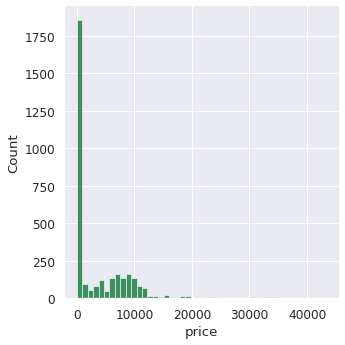

In [ ]:
#Dropping 0 values from price
df = df[df.price > 0]
#Generate price histogram
_=sns.displot(df, x="price")
_.set_titles("Price Histogram")
plt.show()

The first notable thing in our EDA is how discrepant cryptocurrency prices are amongst them. This is evidenced by the Histogram, that clearly presents the distribution of bitcoin and yearn-finance in a larger scale, but has all the prices of litecoin and ethereum concentrated in the first bin. Although we did remedy this using One Hot Encoding, we recognize that this discrepancy will pose limitations for our analysis. 

A breakdown of this effect can be seen in the following price time series detailed by coin.

(735599.0, 737827.0)

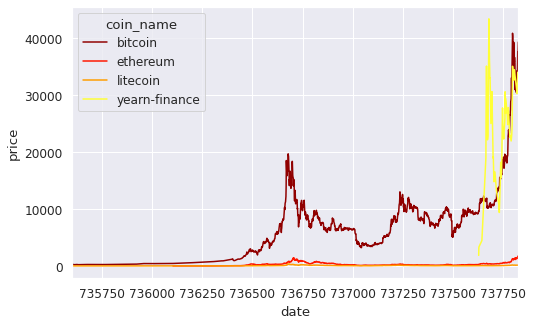

In [ ]:
fig, ax = plt.subplots()
_=sns.lineplot(data=df, x="date",y='price', hue='coin_name', palette='hot')

ax.set_xlim(735599,737827)

(735599.0, 737827.0)

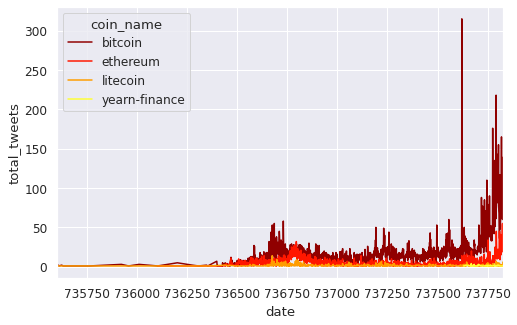

In [ ]:
fig, ax = plt.subplots()
_=sns.lineplot(data=df, x="date",y='total_tweets', hue='coin_name', palette='hot')

ax.set_xlim(735599,737827)

The number of tweets between coins is also discrepant, with Bitcoin obviously being the most popular bitcoin throughout the whole period. However, the difference is less significant than the one observed in price ranges.

Next, we will look into the patterns from the Sentiment Analysis of each coin.

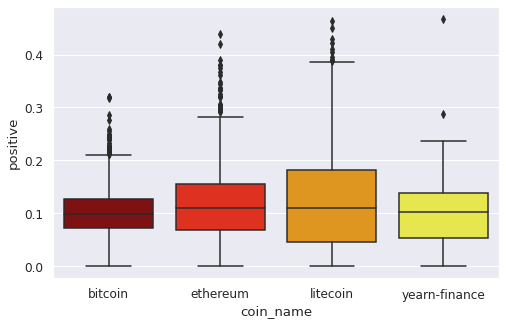

In [ ]:
ax = sns.boxplot(x="coin_name", y="positive", data=df, palette='hot')

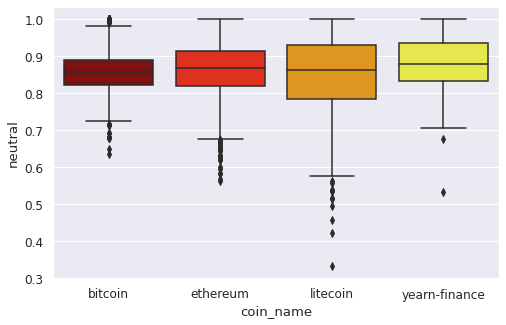

In [ ]:
ax = sns.boxplot(x="coin_name", y="neutral", data=df, palette='hot')

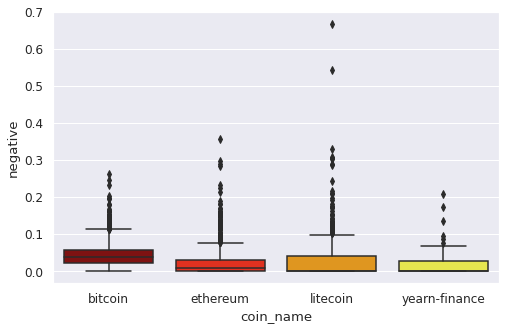

In [ ]:
ax = sns.boxplot(x="coin_name", y="negative", data=df, palette='hot')

The distribution of tweets sentiments also presents slightly different patterns between currencies. The box plots above show that, although they are generally centered in similar points, skewness and variance of observed tweets was different between them.

This reflects how volatile public opinion was for each of those coins, with Bitcoin and Yearn-finance presenting the most consistent results.

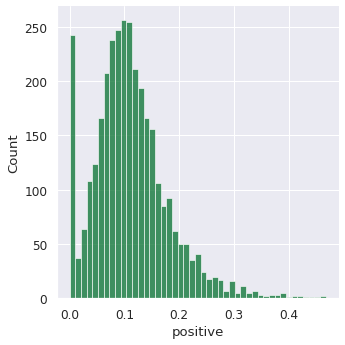

In [ ]:
_=sns.displot(df, x="positive")
_.set_titles("Compound Histogram")
plt.show()

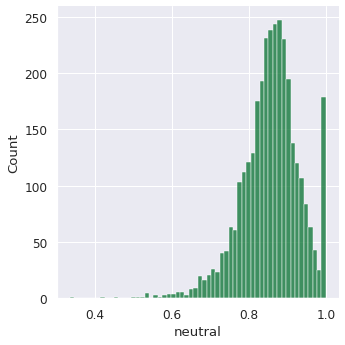

In [ ]:
_=sns.displot(df, x="neutral")
_.set_titles("Compound Histogram")
plt.show()

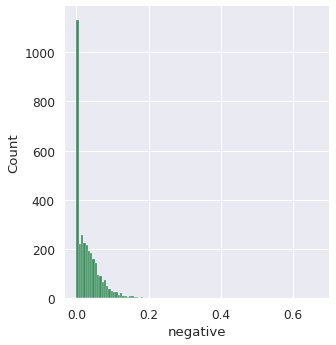

In [ ]:
_=sns.displot(df, x="negative")
_.set_titles("Compound Histogram")
plt.show()

The distributions above show that extracted tweets were mostly positive, with the significant range of negative scores being limited within 0 - 0.2. This indicates that, since posts were mostly neutral or positive, number of tweets will be a significative metric when predicting prices.

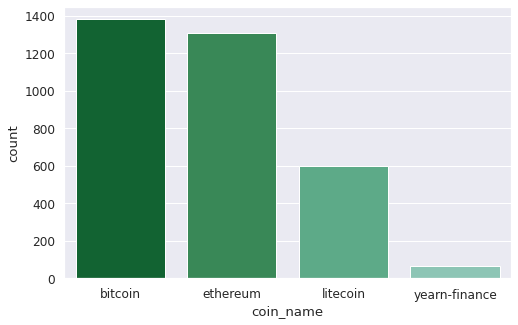

In [ ]:
#Checking amount of data per coin type
sns.countplot(data=df,x='coin_name', order = df['coin_name'].value_counts().index)
plt.show()

We can also see a different amount of datapoints considered for each coin. This happened due to two separate effects. First, the date of entry in the market from a given coin will define different date ranges (and number of data points). Additionally, currencies that were not popular on Twitter (and had many days with 0 tweets being made) had more datapoints excluded from the analysis.

In [ ]:
df = df.drop(['coin_name'], axis=1)
df.columns

Index(['total_vol', 'date', 'price', 'positive', 'negative', 'neutral',
       'total_tweets', 'bitcoin', 'litecoin', 'yearn-finance'],
      dtype='object')

### Variable Relationships

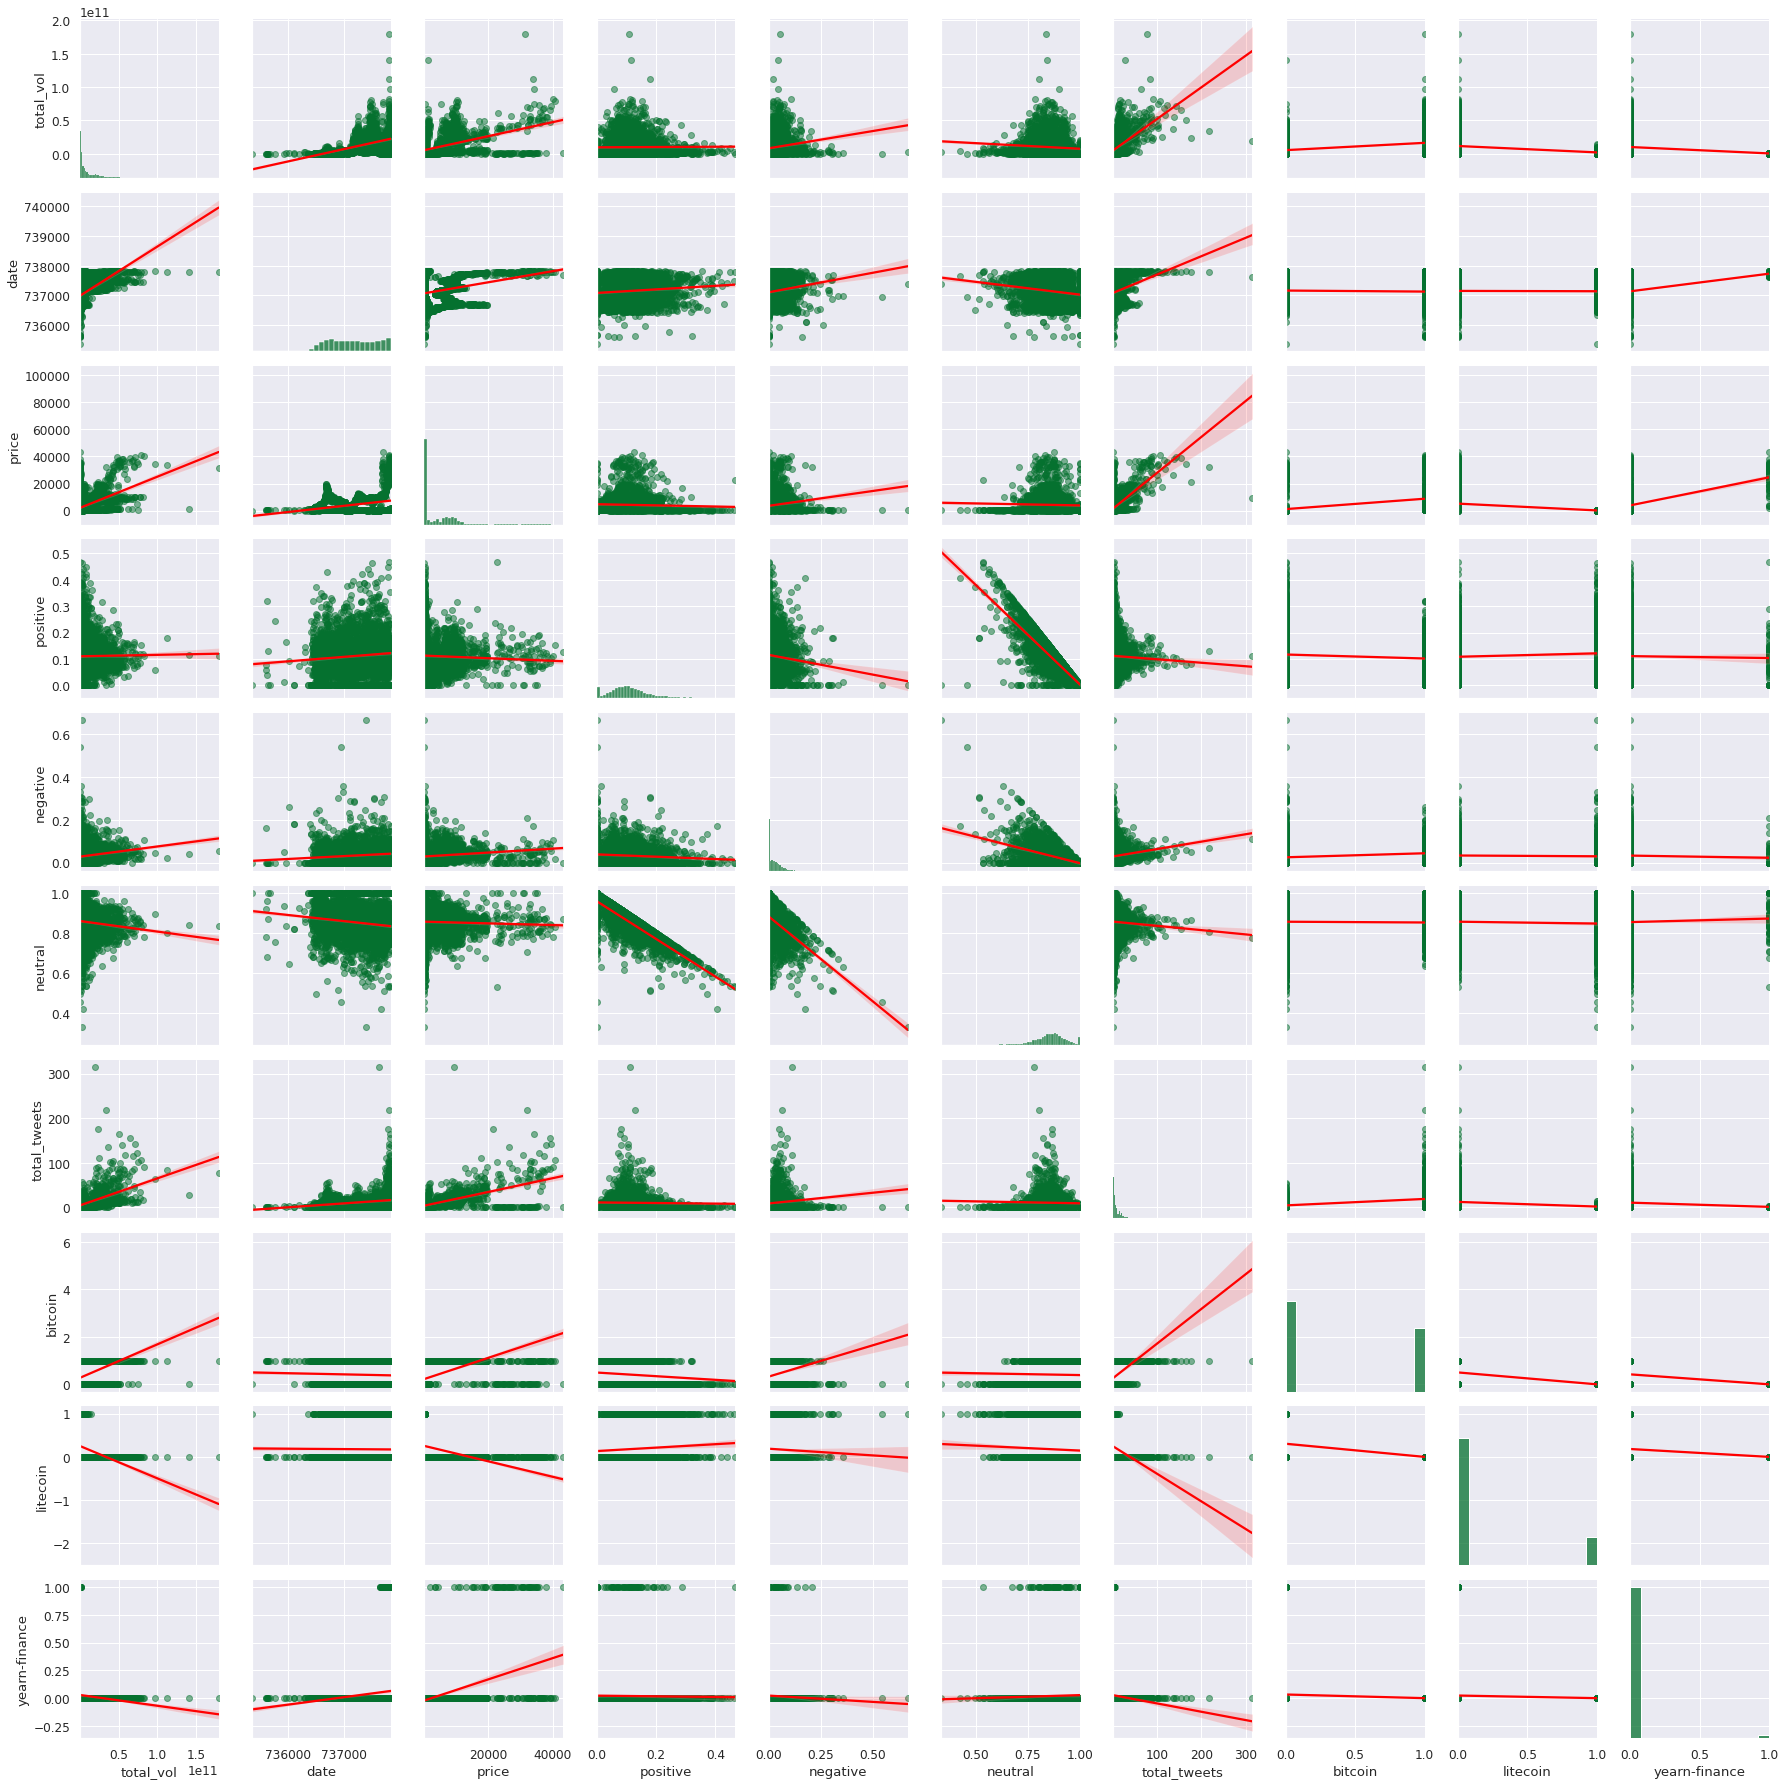

,total_vol,date,price,positive,negative,neutral,total_tweets,bitcoin,litecoin,yearn-finance
total_vol,1.000000,0.557100,0.491750,0.010836,0.156974,-0.094191,0.535723,0.393820,-0.268195,-0.096850
date,0.557100,1.000000,0.293510,0.101364,0.133592,-0.162419,0.234405,-0.041216,-0.009630,0.200367
price,0.491750,0.293510,1.000000,-0.046031,0.141744,-0.035282,0.638046,0.586103,-0.299700,0.443835
positive,0.010836,0.101364,-0.046031,1.000000,-0.090227,-0.843997,-0.029655,-0.107738,0.071416,-0.014859
negative,0.156974,0.133592,0.141744,-0.090227,1.000000,-0.458006,0.128790,0.223305,-0.033652,-0.034240
neutral,-0.094191,-0.162419,-0.035282,-0.843997,-0.458006,1.000000,-0.042920,-0.024098,-0.045695,0.031685
total_tweets,0.535723,0.234405,0.638046,-0.029655,0.128790,-0.042920,1.000000,0.460131,-0.257853,-0.084082
bitcoin,0.393820,-0.041216,0.586103,-0.107738,0.223305,-0.024098,0.460131,1.000000,-0.390421,-0.117803
litecoin,-0.268195,-0.009630,-0.299700,0.071416,-0.033652,-0.045695,-0.257853,-0.390421,1.000000,-0.065637
yearn-finance,-0.096850,0.200367,0.443835,-0.014859,-0.034240,0.031685,-0.084082,-0.117803,-0.065637,1.000000


In [ ]:
sns.pairplot(df, kind='reg', plot_kws={'line_kws':{'color':'red'}, 'scatter_kws': {'alpha': 0.5}})
plt.tight_layout()
plt.show()

df.corr()

The last step in our EDA describes all relationships between our features. From here, we can extract some important insight on coin behavior, like how number of tweets heavily correlates with larger prices. 

A few strange preliminary results can also be seen in the sentiment scores,considering that their correlation with prices do not follow the expected pattern. However, since this is an isolated comparison, we can attribute the results to things such as discrepancies in price ranges and features like number of tweets, sentiment scores, or total volume between coins. We believe that these effects will be remedied by the regression models when the Dummy variables are integrated.

## 3. Feature Scaling

For this step, we used two different scalers to standardize the value ranges. By storing the resulting features from Standard Scaler, Min Max Scaler, and their unscaled counterparts, we were able to compare model performance with each set.

### Separating Features and Response Variable

In [ ]:
df.head()

,total_vol,date,price,positive,negative,neutral,total_tweets,bitcoin,litecoin,yearn-finance
0,4.744626e+10,737827,39279.41287,0.084205,0.066617,0.849145,87.0,1,0,0
1,5.449481e+10,737826,38007.83223,0.081577,0.075804,0.842591,139.0,1,0,0
2,4.976214e+10,737825,36816.50808,0.065362,0.010455,0.924175,60.0,1,0,0
3,5.073070e+10,737824,37494.71762,0.102012,0.023837,0.874128,80.0,1,0,0
4,4.926886e+10,737823,35485.98593,0.185786,0.009167,0.805051,77.0,1,0,0


In [ ]:
# Divide the df into features and response
response = df['price']
features = df.drop('price', axis=1)

### Standard Scaler

In [ ]:
# scale the features
from sklearn.preprocessing import StandardScaler, MinMaxScaler
ss = StandardScaler()

# This will scale the features using the z-score
zscore = ss.fit_transform(features)

#recreate the df
features_ss = pd.DataFrame(zscore, index = features.index, columns = features.columns)
features_ss = features_ss.reset_index(drop=True)
print(features_ss.head())


   total_vol      date  positive  ...   bitcoin  litecoin  yearn-finance
0   2.729533  1.653213 -0.387121  ...  1.194622 -0.466405       -0.14073
1   3.243638  1.650772 -0.425182  ...  1.194622 -0.466405       -0.14073
2   2.898448  1.648331 -0.660067  ...  1.194622 -0.466405       -0.14073
3   2.969093  1.645889 -0.129166  ...  1.194622 -0.466405       -0.14073
4   2.862470  1.643448  1.084341  ...  1.194622 -0.466405       -0.14073

[5 rows x 9 columns]


### MinMax Scaler

In [ ]:
# minmax
mm = MinMaxScaler()
minmax = mm.fit_transform(features)

#create a df again
features_mm = pd.DataFrame(minmax, index=features.index, columns=features.columns)
features_mm = features_mm.reset_index(drop=True)
print(features_mm.head())

   total_vol      date  positive  ...  bitcoin  litecoin  yearn-finance
0   0.265054  0.999595  0.180105  ...      1.0       0.0            0.0
1   0.304432  0.999190  0.174485  ...      1.0       0.0            0.0
2   0.277992  0.998784  0.139803  ...      1.0       0.0            0.0
3   0.283403  0.998379  0.218194  ...      1.0       0.0            0.0
4   0.275236  0.997974  0.397376  ...      1.0       0.0            0.0

[5 rows x 9 columns]


### Declaring an Array of Possible Features to be Used

In [ ]:
features_group = {'standard_scaler': features_ss, 'min_max_scaler': features_mm, 'no_scaling': features}


## 4. Modelling

In [ ]:
#Create a dataframe to store results of different models
results_df = pd.DataFrame()

### 4.1 Linear Regression
We started our modeling process with a Linear Regression, to serve as an initial experiment/baseline for more complex models.

In [ ]:
#import libraries
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [ ]:
for key, curr_features in features_group.items():
    #Separate the data
    X_train, X_test, Y_train, Y_test = train_test_split(curr_features, response,
                                                        test_size=0.25,
                                                        random_state=42)
    # build the model
    model = LinearRegression()
    model.fit(X_train, Y_train)

    # get the predictions for the test dataset
    predictions = model.predict(X_test)

    # R-squared training
    r2_train = model.score(X_train, Y_train)

    # R-squared testing
    r2_test = model.score(X_test, Y_test)

    #Compare predictions with Y_test
    mse = mean_squared_error(Y_test, predictions)

    #Root Mean Squared Error
    rmse=mse**0.5
                    
    results_df = results_df.append({'Model': 'Linear Regression', 'Scaling': key,
                    'RMSE': rmse, 'R2_Test': r2_test, 'R2_Train': r2_train}, ignore_index=True)
    
results_df 

,Model,R2_Test,R2_Train,RMSE,Scaling
0,Linear Regression,0.829807,0.814555,2748.432678,standard_scaler
1,Linear Regression,0.829807,0.814555,2748.432678,min_max_scaler
2,Linear Regression,0.829807,0.814555,2748.432678,no_scaling


We found R Squared above .82 in the testing set, indicating that there is indeed some effect to be captured here by our next models. 

In [ ]:
feat = list(X_train.columns)
coef=model.coef_.transpose()
coef_table = np.stack((feat,coef)).T
df_coef = pd.DataFrame(coef_table, columns=['Feature','Coefficients'])
df_coef

,Feature,Coefficients
0,total_vol,8.570596839550399e-08
1,date,0.20529792992156182
2,positive,-242289.7434645157
3,negative,-245750.81893239287
4,neutral,-243243.20867172844
5,total_tweets,161.48382190153575
6,bitcoin,5565.109378371663
7,litecoin,846.8047757608135
8,yearn-finance,25415.34777035732


Strangely, the coefficient for positive scores identified here was negative. We believe this happened due to the issues discussed in the EDA section of our analysis. However, more robust models will be able to capture the nuances of each coin with more accuracy, and potentially present more reliable results.

The following steps will aggregate new models to the analysis. In the end, we can compare the findings to identify our best predictor. The following models also make use of Cross Validation to find the best combination of parameter for each model, ensuring higher accuracy to our results.

### 4.2 Lasso Regression

In [ ]:
from sklearn.linear_model import Ridge, Lasso 
from sklearn.model_selection import GridSearchCV

In [ ]:
for key, curr_features in features_group.items():
    #Separate the data
    X_train, X_test, Y_train, Y_test = train_test_split(curr_features, response,
                                                        test_size=0.25,
                                                        random_state=42)

    # setting the parameter grid for hyperparameter tuning
    grid_parameters = {'alpha': np.linspace(10,0,100)}

    grid = GridSearchCV(Lasso(), grid_parameters, cv=5, scoring='neg_mean_squared_error')
    grid.fit(X_train, Y_train)
    best_lasso_alpha=grid.best_estimator_.alpha
    
    lasso = Lasso(alpha=best_lasso_alpha)
    
    #fit model
    lasso.fit(X_train, Y_train)
    
    lasso_pred = lasso.predict(X_test)
    
    # R-squared training
    r2_train = lasso.score(X_train, Y_train)

    # R-squared testing
    r2_test = lasso.score(X_test, Y_test)

    mse = np.mean((lasso_pred - Y_test)**2) 
    rmse = mse**0.5

    results_df = results_df.append({'Model': 'Lasso Regression', 'Scaling': key,
                'RMSE': rmse, 'R2_Test': r2_test, 'R2_Train': r2_train, 'Params': 'Alpha = ' + str(best_lasso_alpha)}, ignore_index=True)

#### Evaluation

In [ ]:
results_df

,Model,R2_Test,R2_Train,RMSE,Scaling,Params
0,Linear Regression,0.829807,0.814555,2748.432678,standard_scaler,NaN
1,Linear Regression,0.829807,0.814555,2748.432678,min_max_scaler,NaN
2,Linear Regression,0.829807,0.814555,2748.432678,no_scaling,NaN
3,Lasso Regression,0.829831,0.814503,2748.241563,standard_scaler,Alpha = 10.0
4,Lasso Regression,0.824452,0.812382,2791.336831,min_max_scaler,Alpha = 10.0
5,Lasso Regression,0.829817,0.814526,2748.353635,no_scaling,Alpha = 0.0


Implementing Lasso Regularization did not drastically change the results. This indicates that the amortization of effects from some variables did not produce larger accuracy, evidencing that all features included are indeed relevant to some extent.

### 4.3 Polynomial Regression

#### With Linear Regression

Best degree: {'poly__degree': 2}


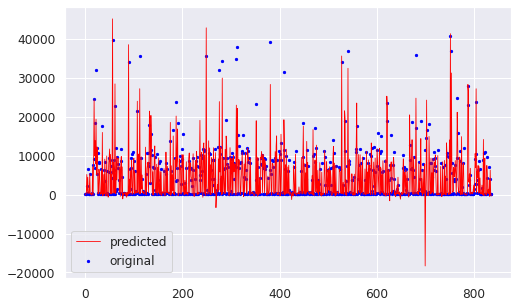

Best degree: {'poly__degree': 2}


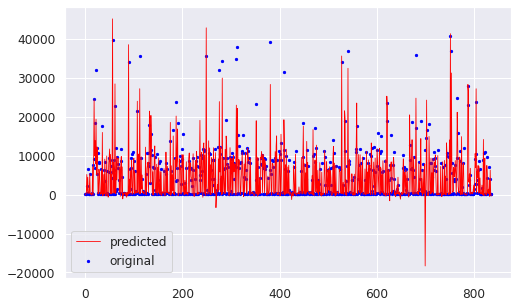

Best degree: {'poly__degree': 2}


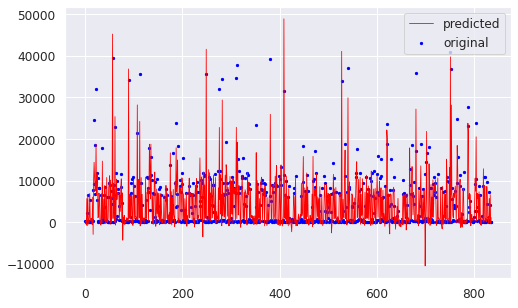

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
for key, curr_features in features_group.items():
    #Separate the data
    X_train_p, X_test_p, Y_train_p, Y_test_p = train_test_split(curr_features, response,
                                                        test_size=0.25,
                                                        random_state=42)

    #generate Polynomial with Linear regression using a range of degrees on CV
    rmse_list=[]
    r2_list =[]
    linear_model = LinearRegression()

    #poly degrees to search
    param_grid = {'poly__degree': np.arange(1,6,1)}

    steps = []
    # create and fit a ridge regression model, testing each alpha
    steps=[('poly', PolynomialFeatures()), ('linear', linear_model)]
    pipeline = Pipeline(steps)

    cv = GridSearchCV(pipeline, param_grid, cv=5, 
                      scoring='neg_mean_squared_error',
                      return_train_score=True)
    #feature_transform=cv.fit_transform(features_p1)
    cv.fit(X_train_p, Y_train_p)
    best_poly_deg = cv.best_params_['poly__degree']
    print("Best degree:", cv.best_params_)   

    #define poly object with degree
    pre_poly = PolynomialFeatures(degree=best_poly_deg)
    #transform X to use in poly
    X_train_poly = pre_poly.fit_transform(X_train_p)
    X_test_poly = pre_poly.transform(X_test_p)
    #create regression object
    pol_reg = LinearRegression()
    #fit model
    pol_reg.fit(X_train_poly, Y_train_p)

    #store predicted price 
    y_predict = pol_reg.predict(X_test_poly)

    #find r-squared
    r2_train = pol_reg.score(X_train_poly, Y_train_p)
    r2_test=pol_reg.score(X_test_poly, Y_test_p)

    #find rmse
    mse = np.mean((y_predict - Y_test_p)**2) 
    rmse=mse**0.5

    # Plot the prediction vs actual values
    x_ax = range(len(y_predict))
    plt.scatter(x_ax, Y_test_p, s=5, color="blue", label="original")
    plt.plot(x_ax, y_predict, lw=0.8, color="red", label="predicted")
    plt.legend()
    plt.show()

    results_df = results_df.append({'Model': 'Polynomial Regression (Linear)', 'Scaling': key, 'Params': 'Degree = ' + str(best_poly_deg),
                'RMSE': rmse, 'R2_Test': r2_test, 'R2_Train': r2_train}, ignore_index=True)

In [ ]:
results_df

,Model,R2_Test,R2_Train,RMSE,Scaling,Params
0,Linear Regression,0.829807,0.814555,2748.432678,standard_scaler,NaN
1,Linear Regression,0.829807,0.814555,2748.432678,min_max_scaler,NaN
2,Linear Regression,0.829807,0.814555,2748.432678,no_scaling,NaN
3,Lasso Regression,0.829831,0.814503,2748.241563,standard_scaler,Alpha = 10.0
4,Lasso Regression,0.824452,0.812382,2791.336831,min_max_scaler,Alpha = 10.0
5,Lasso Regression,0.829817,0.814526,2748.353635,no_scaling,Alpha = 0.0
6,Polynomial Regression (Linear),0.872786,0.894575,2376.189204,standard_scaler,Degree = 2
7,Polynomial Regression (Linear),0.872786,0.894575,2376.191137,min_max_scaler,Degree = 2
8,Polynomial Regression (Linear),0.851140,0.811729,2570.417580,no_scaling,Degree = 2


After applying 2nd degree polynomial transformation, we start to see some improvements to the model (.87 R2 on the testing set). This is in line with the exponential behavior we observed in prices during our EDA.

#### With Lasso

Best degree: {'lasso__alpha': 0.1, 'poly__degree': 2}


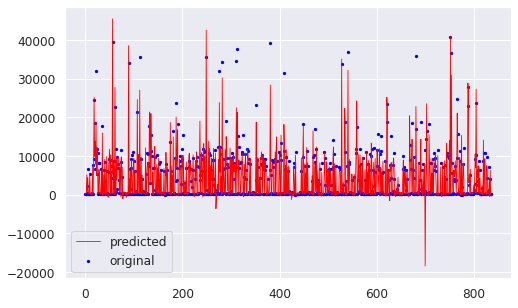

Best degree: {'lasso__alpha': 0.1, 'poly__degree': 2}


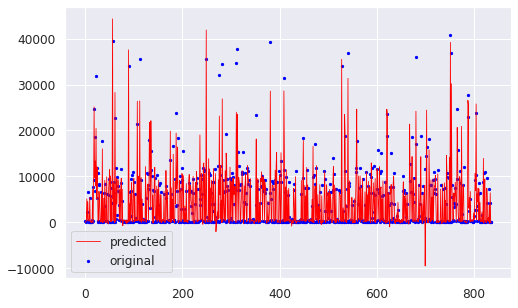

Best degree: {'lasso__alpha': 0.1, 'poly__degree': 2}


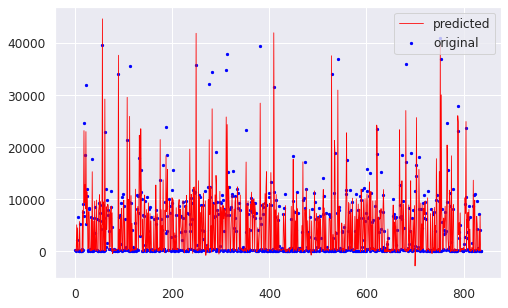

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
for key, curr_features in features_group.items():
    #Separate the data
    X_train_p, X_test_p, Y_train_p, Y_test_p = train_test_split(curr_features, response,
                                                        test_size=0.25,
                                                        random_state=42)
    rmse_list=[]
    r2_list =[]
    
    #poly degrees and lasso alphas to search
    param_grid = {'poly__degree': np.arange(1,6,1),
                  'lasso__alpha': np.linspace(0.001,0.1,10)}

    #create pipeline
    steps = []
    steps=[('poly', PolynomialFeatures()), ('lasso', Lasso())]
    pipeline = Pipeline(steps)

    #gridsearch with 5 folds
    cv = GridSearchCV(pipeline, param_grid, cv=5, 
                      scoring='neg_mean_squared_error',
                      return_train_score=True)
    #feature_transform=cv.fit_transform(features_p1)
    cv.fit(X_train, Y_train)
    print("Best degree:", cv.best_params_) 

    #obtain hyperparameters
    best_poly_deg = cv.best_params_['poly__degree']
    best_lasso_alpha = cv.best_params_['lasso__alpha']

    #define poly object with degree
    pre_poly = PolynomialFeatures(degree=best_poly_deg)
    #transform X to use in poly
    X_train_poly = pre_poly.fit_transform(X_train_p)
    X_test_poly = pre_poly.transform(X_test_p)
    #create regression object
    pol_reg = Lasso(best_lasso_alpha)
    #fit model
    pol_reg.fit(X_train_poly, Y_train_p)

    #store predicted price 
    y_predict = pol_reg.predict(X_test_poly)

    #find r-squared
    r2_train = pol_reg.score(X_train_poly, Y_train_p)
    r2_test=pol_reg.score(X_test_poly, Y_test_p)

    #find rmse
    mse = np.mean((y_predict - Y_test_p)**2) 
    rmse=mse**0.5

    # Plot the prediction vs actual values
    x_ax = range(len(y_predict))
    plt.scatter(x_ax, Y_test_p, s=5, color="blue", label="original")
    plt.plot(x_ax, y_predict, lw=0.8, color="red", label="predicted")
    plt.legend()
    plt.show()

    results_df = results_df.append({'Model': 'Polynomial Regression (Lasso)', 'Scaling': key,
                'RMSE': rmse, 'R2_Test': r2_test, 'R2_Train': r2_train, 'Params': 'Alpha = ' + str(best_lasso_alpha) + '; Degree = ' + str(best_poly_deg) }, ignore_index=True)

In [ ]:
results_df

,Model,R2_Test,R2_Train,RMSE,Scaling,Params
0,Linear Regression,0.829807,0.814555,2748.432678,standard_scaler,NaN
1,Linear Regression,0.829807,0.814555,2748.432678,min_max_scaler,NaN
2,Linear Regression,0.829807,0.814555,2748.432678,no_scaling,NaN
3,Lasso Regression,0.829831,0.814503,2748.241563,standard_scaler,Alpha = 10.0
4,Lasso Regression,0.824452,0.812382,2791.336831,min_max_scaler,Alpha = 10.0
5,Lasso Regression,0.829817,0.814526,2748.353635,no_scaling,Alpha = 0.0
6,Polynomial Regression (Linear),0.872786,0.894575,2376.189204,standard_scaler,Degree = 2
7,Polynomial Regression (Linear),0.872786,0.894575,2376.191137,min_max_scaler,Degree = 2
8,Polynomial Regression (Linear),0.851140,0.811729,2570.417580,no_scaling,Degree = 2
9,Polynomial Regression (Lasso),0.868759,0.893497,2413.511008,standard_scaler,Alpha = 0.1; Degree = 2


Adding Lasso Regularization to the Polynomial transformed model had similar impact to the Linear step. Again, this provides evidence to support the significance of all features in our model.

### 4.4 Decision Tree Regressor

In [ ]:
from sklearn.tree import DecisionTreeRegressor

In [ ]:
for key, curr_features in features_group.items():
    #Separate the data
    X_train, X_test, Y_train, Y_test = train_test_split(curr_features, response,
                                                        test_size=0.25,
                                                        random_state=42)

    # setting the parameter grid for hyperparameter tuning
    grid_parameters = {'max_depth': np.arange(2,10,1)}

    grid = GridSearchCV(DecisionTreeRegressor(), grid_parameters, cv=5, scoring='neg_mean_squared_error')
    grid.fit(X_train, Y_train)
    best_para=grid.best_estimator_.max_depth
  
    dec_reg = DecisionTreeRegressor(max_depth=best_para)
    
    #fit model
    dec_reg.fit(X_train, Y_train)
    
    dec_pred = dec_reg.predict(X_test)
    
    # R-squared training
    r2_train = dec_reg.score(X_train, Y_train)

    # R-squared testing
    r2_test = dec_reg.score(X_test, Y_test)

    mse = np.mean((dec_pred - Y_test)**2) 
    rmse = mse**0.5

    results_df = results_df.append({'Model': 'Decision Tree Regressor', 'Scaling': key,
                'RMSE': rmse, 'R2_Test': r2_test, 'R2_Train': r2_train, 'Params': 'max_depth = ' + str(best_para)}, ignore_index=True)

In [ ]:
results_df

,Model,R2_Test,R2_Train,RMSE,Scaling,Params
0,Linear Regression,0.829807,0.814555,2748.432678,standard_scaler,NaN
1,Linear Regression,0.829807,0.814555,2748.432678,min_max_scaler,NaN
2,Linear Regression,0.829807,0.814555,2748.432678,no_scaling,NaN
3,Lasso Regression,0.829831,0.814503,2748.241563,standard_scaler,Alpha = 10.0
4,Lasso Regression,0.824452,0.812382,2791.336831,min_max_scaler,Alpha = 10.0
5,Lasso Regression,0.829817,0.814526,2748.353635,no_scaling,Alpha = 0.0
6,Polynomial Regression (Linear),0.872786,0.894575,2376.189204,standard_scaler,Degree = 2
7,Polynomial Regression (Linear),0.872786,0.894575,2376.191137,min_max_scaler,Degree = 2
8,Polynomial Regression (Linear),0.851140,0.811729,2570.417580,no_scaling,Degree = 2
9,Polynomial Regression (Lasso),0.868759,0.893497,2413.511008,standard_scaler,Alpha = 0.1; Degree = 2


Now the results start to get interesting. The Decision Tree Regressor presented significantly better results than its predecessors. We believe this makes a lot of sense when considering the nature of our data. Since coins have very discrepant behaviors between them, the effects of analyzing subsets in a Decision Tree resulted in more reliable results, providing a more accurate direction for prices in different currencies.


## 4.5 RandomForest Regressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
for key, curr_features in features_group.items():
    #Separate the data
    X_train, X_test, Y_train, Y_test = train_test_split(curr_features, response,
                                                        test_size=0.25,
                                                        random_state=42)

    # setting the parameter grid for hyperparameter tuning
    grid_parameters = {'max_depth': np.arange(2,10,1)}

    grid = GridSearchCV(RandomForestRegressor(), grid_parameters, cv=5, scoring='neg_mean_squared_error')
    grid.fit(X_train, Y_train)
    best_para=grid.best_estimator_.max_depth
  
    rf_reg = RandomForestRegressor(max_depth=best_para, max_features=None)
    
    #fit model
    rf_reg.fit(X_train, Y_train)
    
    rf_pred = rf_reg.predict(X_test)
    
    # R-squared training
    r2_train = rf_reg.score(X_train, Y_train)

    # R-squared testing
    r2_test = rf_reg.score(X_test, Y_test)

    mse = np.mean((rf_pred - Y_test)**2) 
    rmse = mse**0.5

    results_df = results_df.append({'Model': 'RandomForest Regressor', 'Scaling': key,
                'RMSE': rmse, 'R2_Test': r2_test, 'R2_Train': r2_train, 'Params': 'max_depth = ' + str(best_para)}, ignore_index=True)

In [ ]:
results_df = results_df.sort_values(by=['RMSE'])
results_df

,Model,R2_Test,R2_Train,RMSE,Scaling,Params
17,RandomForest Regressor,0.988675,0.994798,708.980808,standard_scaler,max_depth = 9
19,RandomForest Regressor,0.987454,0.994859,746.232236,no_scaling,max_depth = 9
18,RandomForest Regressor,0.985835,0.994147,792.912607,min_max_scaler,max_depth = 9
16,Decision Tree Regressor,0.985795,0.995127,794.034003,no_scaling,max_depth = 9
14,Decision Tree Regressor,0.985509,0.995127,801.978243,standard_scaler,max_depth = 9
15,Decision Tree Regressor,0.984582,0.991914,827.226309,min_max_scaler,max_depth = 8
13,Polynomial Regression (Lasso),0.879234,0.884052,2315.189461,no_scaling,Alpha = 0.1; Degree = 2
12,Polynomial Regression (Lasso),0.878033,0.889425,2326.670995,min_max_scaler,Alpha = 0.1; Degree = 2
10,Polynomial Regression (Lasso),0.878033,0.889425,2326.670995,min_max_scaler,Alpha = 0.1; Degree = 2
6,Polynomial Regression (Linear),0.872786,0.894575,2376.189204,standard_scaler,Degree = 2


Adding a Random Forest regressor to our model tookk the results one step further. The randomization of trees proved to be an extremely reliable way to handle the different coin behaviors and price ranges.

This model reached above .98 score in the testing set, indicating a very high accuracy in our predictor.

Draw one tree from random forest

In [ ]:
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot # Pull out one tree from the forest

tree = rf_reg.estimators_[10]
feature_list = list(curr_features.columns)

export_graphviz(tree, out_file = 'tree.dot', feature_names = feature_list, rounded = True, precision = 1)# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')# Write graph to a png file
graph.write_png('tree.png')

## 5. Neural Network

In [ ]:
import math
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import seed
seed(1)
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import tensorflow
tensorflow.random.set_seed(1)
from tensorflow.python.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.metrics import r2_score
from keras.callbacks import EarlyStopping

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 398)               3980      
_________________________________________________________________
dense_1 (Dense)              (None, 199)               79401     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 200       
Total params: 83,581
Trainable params: 83,581
Non-trainable params: 0
_________________________________________________________________
dict_keys(['loss', 'mse', 'mae', 'val_loss', 'val_mse', 'val_mae'])


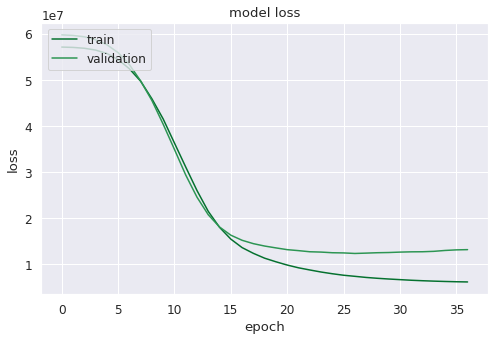

2663.408036391092
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 398)               3980      
_________________________________________________________________
dense_4 (Dense)              (None, 199)               79401     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 200       
Total params: 83,581
Trainable params: 83,581
Non-trainable params: 0
_________________________________________________________________
dict_keys(['loss', 'mse', 'mae', 'val_loss', 'val_mse', 'val_mae'])


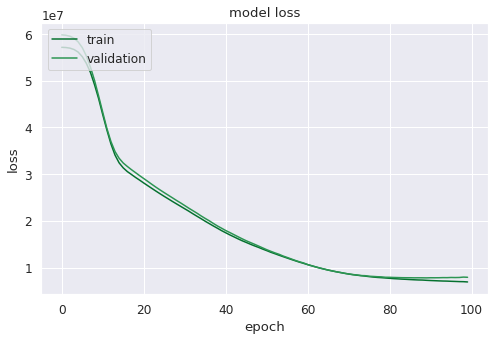

2802.228394017235


In [ ]:
# Simple NN
#Loop through our different sets of features
for key, curr_features in features_group.items():

    #Skip non-scaled features
    if key == 'no_scaling':
      continue

    #Separate the data
    X_train, X_test, Y_train, Y_test = train_test_split(curr_features, response,
                                                            test_size=0.25,
                                                            random_state=42)

    # Hidden layer neurons = Training Data Samples/ (Factor * (Input Neurons + Output Neurons))
    # Considering the 4788 input rows, and a factor of 4 for the first hidden layer: 398 neurons (177 354)

    model = Sequential()
    model.add(Dense(398, input_dim=9, kernel_initializer='normal', activation='relu'))
    model.add(Dense(199, activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.summary()

    model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])
    history=model.fit(X_train, Y_train, epochs=150, batch_size=150, verbose=0, validation_split=0.2
                      , callbacks=[EarlyStopping( monitor='val_loss', patience=10)])
    predictions_train = model.predict(X_train)
    predictions = model.predict(X_test)

    print(history.history.keys())
    # "Loss"
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

    rmse = mean_squared_error(Y_test, predictions) ** 0.5
    
    # R-squared training
    r2_train = r2_score(Y_train, predictions_train)

    # R-squared testing
    r2_test = r2_score(Y_test, predictions)
    
    results_df = results_df.append({'Model': 'Neural Network', 'Scaling': key, 'Params': 'See NN topology',
                'RMSE': rmse, 'R2_Test': r2_test, 'R2_Train': r2_train}, ignore_index=True)
    print(rmse)


In [ ]:
results_df = results_df.sort_values(by=['RMSE'])
results_df

,Model,R2_Test,R2_Train,RMSE,Scaling,Params
0,RandomForest Regressor,0.988675,0.994798,708.980808,standard_scaler,max_depth = 9
1,RandomForest Regressor,0.987454,0.994859,746.232236,no_scaling,max_depth = 9
2,RandomForest Regressor,0.985835,0.994147,792.912607,min_max_scaler,max_depth = 9
3,Decision Tree Regressor,0.985795,0.995127,794.034003,no_scaling,max_depth = 9
4,Decision Tree Regressor,0.985509,0.995127,801.978243,standard_scaler,max_depth = 9
5,Decision Tree Regressor,0.984582,0.991914,827.226309,min_max_scaler,max_depth = 8
6,Polynomial Regression (Lasso),0.879234,0.884052,2315.189461,no_scaling,Alpha = 0.1; Degree = 2
7,Polynomial Regression (Lasso),0.878033,0.889425,2326.670995,min_max_scaler,Alpha = 0.1; Degree = 2
8,Polynomial Regression (Lasso),0.878033,0.889425,2326.670995,min_max_scaler,Alpha = 0.1; Degree = 2
9,Polynomial Regression (Linear),0.872786,0.894575,2376.189204,standard_scaler,Degree = 2


Our last experiment included sequential Neural Networks to attempt to improve the Random Forest Regressor results. We used early stopping to avoid overfitting, reaching an acceptable accuracy of .84 in the testing set. 

However, the best predictor we found continues to be the Random Forest Regressor, with exceptionally accurate results and an RMSE of 708.98. With this accuracy, we believe we reached a powerful estimator for cryptocurrency price prediction.

# 6. Predicting New Prices
- The final step in our analysis will consist in predicting a set of prices for new unseen data.
- To do that, we will predict different scenarios using Bitcoin as an example:
  - Positive tweets scenario (pos=0.9 & neu=0.1)
  - Neutral tweets scenario (neu=1)
  - Negative tweets scenario (neg=0.9 & neu=0.1)
  - Large number of tweets (n_tweets=500)
  - Small number of tweets (n_tweets=10)

In [ ]:
print(features.columns)

Index(['total_vol', 'date', 'positive', 'negative', 'neutral', 'total_tweets',
       'bitcoin', 'litecoin', 'yearn-finance'],
      dtype='object')


In [ ]:
# Creating a dataframe for new predictions
data_new = [
    # Positive tweets scenario
    [150000000000, '08-02-2021', 0.9, 0, 0.1, 100, 1, 0, 0],
    # Neutral tweets scenario    
    [150000000000, '08-02-2021', 0, 0, 1, 100, 1, 0, 0],
    # Negative tweets scenario
    [150000000000, '08-02-2021', 0, 0.9, 0.1, 100, 1, 0, 0],
    # Large number of tweets
    [150000000000, '08-02-2021', 0, 0, 1, 500, 1, 0, 0],
    # Small number of tweets
    [150000000000, '08-02-2021', 0, 0, 1, 10, 1, 0, 0]
           ]

df_new = pd.DataFrame(data_new, columns = ['total_vol', 'date', 'positive', 'negative', 'neutral', 'total_tweets',
       'bitcoin', 'litecoin', 'yearn-finance'])

#Converting dates to ordinal
df_new['date']=pd.to_datetime(df_new['date'], format='%d-%m-%Y').dt.strftime('%Y-%m-%d')
df_new['date']=pd.to_datetime(df_new['date']).map(dt.datetime.toordinal)


In [ ]:
# scaler = StandardScaler()
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features_group['no_scaling'])
scaled_new = scaler.transform(df_new)


In [ ]:
rf_reg = RandomForestRegressor(max_depth=9, max_features=None,
                                                    random_state=42)

#fit model
rf_reg.fit(scaled_features, response)

predictions = rf_reg.predict(scaled_new)

print("Example - applying model for new predictions:")
print("Pos tweets\tNeu tweets\tNeg tweets\tMany tweets\tFew tweets")
print(predictions)

Example - applying model for new predictions:
Pos tweets	Neu tweets	Neg tweets	Many tweets	Few tweets
[36745.24480911 36410.61652901 36343.9182751  36726.04913617
 35827.24745682]


## Final Comments:
- With our final models, we predicted different scenarios in which positive, negative, and neutral tweets in large and small amounts impact price.
- The following approximate predictions were made by the model:
  - Positive tweets scenario: 36745.24
  - Neutral tweets scenario: 36410.62
  - Negative tweets scenario: 36343.92
  - Large number of (neutral) tweets scenario: 36726.05
  - Small number of (neutral) tweets scenario: 35827.25

  - Model Accuracy on the testing set: 98.87%

- Since we are using RandomForest, it is impossible to extract meaningfull coefficients from the model as we would do with a simple regression.
- However, we can see from the results that positive citations on twitter affect price positively, while negative tweets render a lower predicted price.
- Similarly, having a large number of tweets also seems to impact price positively.
- Although this model presented strong results, the predicted values are slightly offset from the currently observed Bitcoin prices. We believe this is occurring because of the discrepant price ranges and behaviors between coins, posing a limitation for better predictions. 
  - A challenge we faced developing this academic project was only having free access to daily prices of currencies. As a potential improvement, implementing these models using more granular data (e.g. hourly or minute prices) would give us enough data points to train individual models for each coin. We believe that this would generate even better and more reliable results for practical applications.
  